## Detection algorithm 

In [11]:
#-*- coding=utf-8 -*-
import requests
import json
import time
import hashlib
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from numpy import linalg as LA
from os import listdir
from os.path import isfile, join
from datetime import datetime
import os, sys, errno
import threading
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

%matplotlib inline

class Car_Detection:
    def __init__(self, MagX, MagY, MagZ ):
        self.MagX_init = MagX
        self.MagY_init = MagY
        self.MagZ_init = MagZ
        self.MagLen_init = (MagX**2 + MagY **2 + MagZ**2)**(0.5)
        self.cos_alpha_init = self.MagX_init / self.MagLen_init
        self.cos_beta_init  = self.MagY_init / self.MagLen_init
        self.cos_gamma_init = self.MagZ_init / self.MagLen_init
        self.index_performance_XY_plane = 0
    
    def get_mag_length(self, MagX, MagY, MagZ):
        return (MagX**2 + MagY **2 + MagZ**2)**(0.5)
        
    # "Analysis of Magnetic Field Disturbance Curve for Vehicle Presence Detection"
    def detect_1_Zcompoment_norm(self, MagX, MagY, MagZ):
        Z_compoment = 1000* (MagZ / self.MagZ_init - 1)
        return Z_compoment
    
    def detect_2_performance_XY_plane(self, MagX, MagY, MagZ):
        P = (MagX - MagY) / (MagX**2 + MagY **2)**(0.5)
        return P

    def detect_3_cosine_variations_product_XY_plane(self, MagX, MagY, MagZ):
        MagLen = self.get_mag_length(MagX, MagY, MagZ)
        X_part = MagX / MagLen - self.MagX_init / self.MagLen_init
        Y_part = MagY / MagLen - self.MagY_init / self.MagLen_init
        CP     = X_part / Y_part
        return CP
    
    def detect_4_cosine_variations_Kcriterion(self, MagX, MagY, MagZ):
        MagLen = self.get_mag_length(MagX, MagY, MagZ)
        X_part = MagX / MagLen - self.MagX_init / self.MagLen_init
        Y_part = MagY / MagLen - self.MagY_init / self.MagLen_init
        Z_part = MagZ / self.MagZ_init - 1
        K      = 100 * (abs(X_part) + abs(Y_part) + Z_part)
        return K
   
    
    # "Vehicle Influence on the Earth’s Magnetic Field Changes"    
    def detect_5_square_deviation(self, MagX, MagY, MagZ):
        K = self.get_mag_length(MagX - self.MagX_init, MagY - self.MagY_init, MagZ - self.MagZ_init)
        return K    
    
    def detect_6_vectorial_deviation(self, MagX, MagY, MagZ):
        MagLen = self.get_mag_length(MagX, MagY, MagZ)
        cos_alpha = MagX / MagLen
        cos_beta  = MagY / MagLen
        cos_gamma = MagZ / MagLen
        K = abs(cos_alpha - self.cos_alpha_init) + abs(cos_beta - self.cos_beta_init) + \
            abs(cos_gamma - self.cos_gamma_init)
        return K   

    def detect_7_combined_vectorial_deviation(self, MagX, MagY, MagZ):
        MagLen = self.get_mag_length(MagX, MagY, MagZ)
        cos_alpha = MagX / MagLen
        cos_beta  = MagY / MagLen
        K = abs(cos_alpha - self.cos_alpha_init) + abs(cos_beta - self.cos_beta_init) + \
        (MagZ / self.MagZ_init - 1)
        return K   

    def detect_8_weighting_vectorial_deviation(self, MagX, MagY, MagZ):
        Kd = 20 # mG
        Z_compoment = MagZ / self.MagZ_init - 1
        # if Z_compoment > -Kd, weight = 1 
        # if Z_compoment < -Kd, weight = -1 
        if Z_compoment > -Kd:
            weight = 1
        else:
            weight = -1
            
        MagLen = self.get_mag_length(MagX, MagY, MagZ)
        cos_alpha = MagX / MagLen
        cos_beta  = MagY / MagLen
        
        K = abs(cos_alpha - self.cos_alpha_init) + abs(cos_beta - self.cos_beta_init) + \
            weight * Z_compoment
        return K   

    def detect_9_each_axis_difference(self, MagX, MagY, MagZ):
        MagX_offset = MagX - self.MagX_init
        MagY_offset = MagY - self.MagY_init
        MagZ_offset = MagZ - self.MagZ_init
        
        K = abs(MagX_offset - MagY_offset) + abs(MagX_offset - MagZ_offset) + \
            abs(MagY_offset - MagZ_offset)
        return K   
    
    def detect_10_each_axis_distance(self, MagX, MagY, MagZ):
        MagX_offset = MagX - self.MagX_init
        MagY_offset = MagY - self.MagY_init
        MagZ_offset = MagZ - self.MagZ_init
        
        K = abs(MagX_offset) + abs(MagY_offset) + abs(MagZ_offset)
        return K 
#################### function list ###################
def check_file_path_exist(csvName):
    if not os.path.exists(os.path.dirname(csvName)):
        try:
            os.makedirs(os.path.dirname(csvName))
        except OSError as exc: # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise
                
def get_mag_len(df, mag_number):
    for i in range(mag_number):
        df["Mag" + str(i+1) + "_Len"] = (df["Mag" + str(i+1) +"_X"].pow(2) + df["Mag" + str(i+1) +"_Y"].pow(2) + df["Mag" + str(i+1) +"_Z"].pow(2) ).pow(0.5)
    return df

def get_mag_env(df, mag_number, offset_points):
    for i in range(mag_number):
        df["Mag" + str(i+1) + "_EnvX"] = df["Mag" + str(i+1) +"_X"][:offset_points].mean()
        df["Mag" + str(i+1) + "_EnvY"] = df["Mag" + str(i+1) +"_Y"][:offset_points].mean()
        df["Mag" + str(i+1) + "_EnvZ"] = df["Mag" + str(i+1) +"_Z"][:offset_points].mean()
    return df

def get_mag_car_field(df, mag_number):
    for i in range(mag_number):
        df["Mag" + str(i+1) + "_CarX"] = df["Mag" + str(i+1) +"_X"] - df["Mag" + str(i+1) + "_EnvX"]
        df["Mag" + str(i+1) + "_CarY"] = df["Mag" + str(i+1) +"_Y"] - df["Mag" + str(i+1) + "_EnvY"]
        df["Mag" + str(i+1) + "_CarZ"] = df["Mag" + str(i+1) +"_Z"] - df["Mag" + str(i+1) + "_EnvZ"]
        df["Mag" + str(i+1) + "_CarLen"] = (df["Mag" + str(i+1) +"_CarX"].pow(2) + df["Mag" + str(i+1) +"_CarY"].pow(2) + df["Mag" + str(i+1) +"_CarZ"].pow(2) ).pow(0.5)
    return df    

def get_car_brand(df, brand, category):
    df["Brand"] = brand
    df["Category"] = category
    df = df[sorted(df.columns)]
    return df 

def get_car_in_out_type(df, in_out_type):
    d_zeros = pd.DataFrame(np.zeros(df.shape[0], ))
    d_ones  = pd.DataFrame(np.ones (df.shape[0], ))
    df.insert(2, "Forward", d_zeros) 
    df.insert(3, "Backward", d_zeros) 
    df.insert(4, "Sideway", d_zeros) 

    if in_out_type == "Forward":
        df["Forward"] = 1
    elif in_out_type == "Backward":
        df["Backward"] = 1
    elif in_out_type == "Sideway":
        df["Sideway"] = 1
    else:
        print("car_in_out_type : error input")
    return df 

def get_kmean_label(df, feature):
    random_state = 170
    X_filtered = df[feature].as_matrix()
    Kmean_model = KMeans(n_clusters=3, random_state=random_state)
    y_pred = Kmean_model.fit_predict(X_filtered)
    df["Class"] = y_pred * df["Mag1_CarLen"].max()/2
    print("Cluster centers ", Kmean_model.cluster_centers_ )
    return df


In [12]:
Rawdata_folderName = os.getcwd() + '/Detection_Database/Raw/'
Prasedata_folderName = os.getcwd() + '/Detection_Database/New/'
check_file_path_exist(Rawdata_folderName)
check_file_path_exist(Prasedata_folderName)

csvFiles = [f for f in listdir(Rawdata_folderName) if isfile(join(Rawdata_folderName, f)) and f[-3:] == "csv" ]

In [13]:
csvFiles

['clotplus_back_in.csv',
 'clotplus_forward_in.csv',
 'tercel_backward_in.csv',
 'tercel_forward_in.csv']

Cluster centers  [[   0.30793651   -2.74550265    0.27248677]
 [  -8.3954023  -182.19195402   13.05172414]
 [ -43.2         -52.01666667  -11.33333333]]


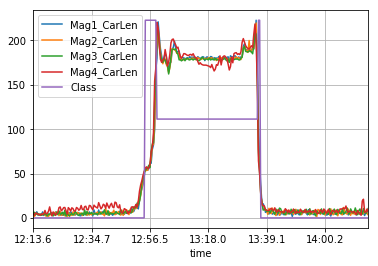

In [20]:
csvFile =  csvFiles[3]
csvName = Rawdata_folderName + csvFile
csvNewName = Prasedata_folderName + "New_" + csvFile

if csvFile.find("back") != -1:
    car_in_out_type = "Backward"
elif csvFile.find("forward") != -1:
    car_in_out_type = "Forward"
elif csvFile.find("side") != -1:
    car_in_out_type = "Sideway"
    
Experiment_Mag_number = 4
Experiment_Mag_Env_number = 10
car_brand = "toyota"
car_category = "clotplus"

df = pd.read_csv(csvName)
df = get_mag_len(df, Experiment_Mag_number)
df = get_mag_env(df, Experiment_Mag_number, Experiment_Mag_Env_number)
df = get_mag_car_field(df, Experiment_Mag_number)
df = get_car_brand(df, car_brand, car_category)
df = get_car_in_out_type(df, car_in_out_type)

# clustering
Kmean_feature = ["Mag1_CarX","Mag1_CarY","Mag1_CarZ"]
df = get_kmean_label(df, Kmean_feature)

df.to_csv(csvNewName)

plt.figure(); 
df.plot(x='time', y=['Mag1_CarLen','Mag2_CarLen','Mag3_CarLen','Mag4_CarLen', 'Class'], grid = True);

Cluster centers  [[   0.30793651   -2.74550265    0.27248677]
 [  -8.3954023  -182.19195402   13.05172414]
 [ -43.2         -52.01666667  -11.33333333]]


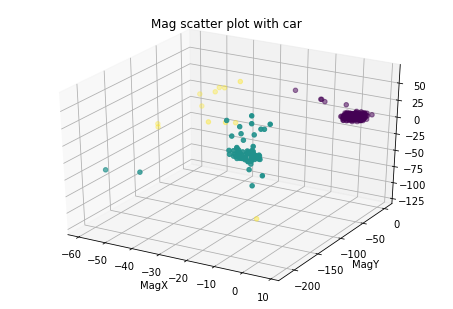

In [15]:
random_state = 170
X_filtered = df[["Mag1_CarX","Mag1_CarY","Mag1_CarZ"]].as_matrix()
Kmean_model = KMeans(n_clusters=3, random_state=random_state)
y_pred = Kmean_model.fit_predict(X_filtered)

print("Cluster centers ", Kmean_model.cluster_centers_ )

fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(X_filtered[:,0], X_filtered[:,1], X_filtered[:,2], c=y_pred)
plt.title('Mag scatter plot with car')
plt.xlabel('MagX')
plt.ylabel('MagY')

 
plt.show()


## test algorithm 

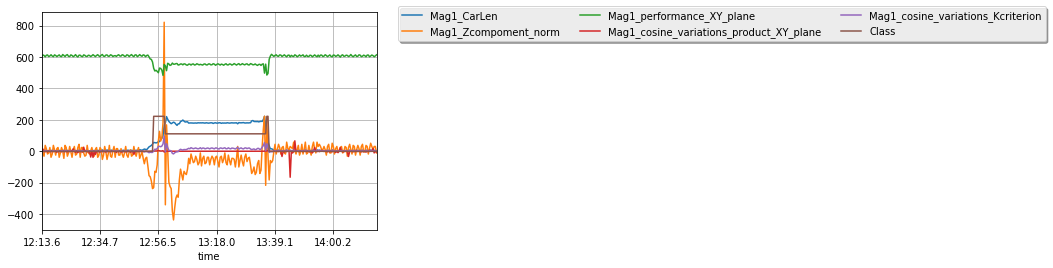

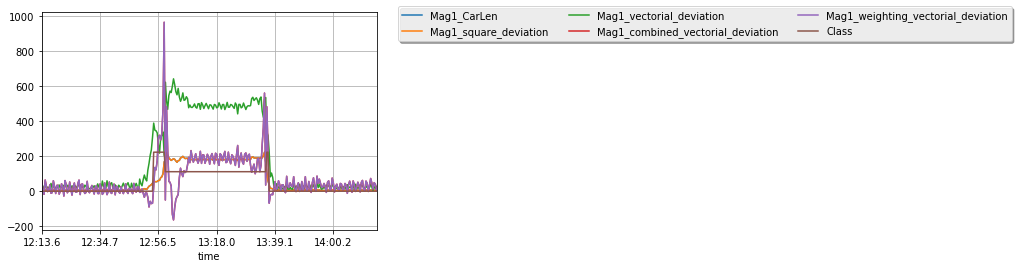

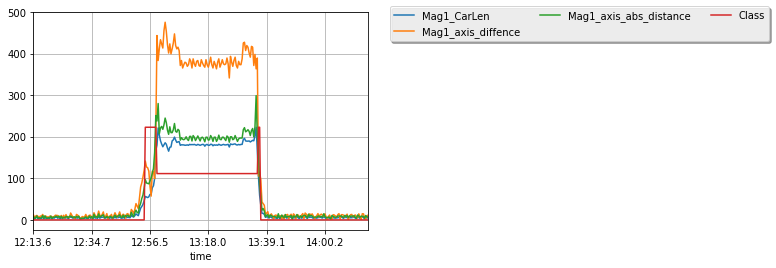

In [19]:
EnvX = df['Mag1_EnvX'][0]
EnvY = df['Mag1_EnvY'][0]
EnvZ = df['Mag1_EnvZ'][0]
Detection = Car_Detection(EnvX, EnvY, EnvZ)

# implement detection method(10)
df["Mag1_Zcompoment_norm"] = df.apply(lambda row: Detection.detect_1_Zcompoment_norm(row['Mag1_X'], row['Mag1_Y'], row['Mag1_Z']), axis = 1)
df["Mag1_performance_XY_plane"] = 500 * df.apply(lambda row: Detection.detect_2_performance_XY_plane(row['Mag1_X'], row['Mag1_Y'], row['Mag1_Z']), axis = 1)
df["Mag1_cosine_variations_product_XY_plane"] = df.apply(lambda row: Detection.detect_3_cosine_variations_product_XY_plane(row['Mag1_X'], row['Mag1_Y'], row['Mag1_Z']), axis = 1)
df["Mag1_cosine_variations_Kcriterion"] = df.apply(lambda row: Detection.detect_4_cosine_variations_Kcriterion(row['Mag1_X'], row['Mag1_Y'], row['Mag1_Z']), axis = 1)
df["Mag1_square_deviation"] = df.apply(lambda row: Detection.detect_5_square_deviation(row['Mag1_X'], row['Mag1_Y'], row['Mag1_Z']), axis = 1)
df["Mag1_vectorial_deviation"] = 1000 * df.apply(lambda row: Detection.detect_6_vectorial_deviation(row['Mag1_X'], row['Mag1_Y'], row['Mag1_Z']), axis = 1)
df["Mag1_combined_vectorial_deviation"] = 1000 * df.apply(lambda row: Detection.detect_7_combined_vectorial_deviation(row['Mag1_X'], row['Mag1_Y'], row['Mag1_Z']), axis = 1)
df["Mag1_weighting_vectorial_deviation"] = 1000 * df.apply(lambda row: Detection.detect_8_weighting_vectorial_deviation(row['Mag1_X'], row['Mag1_Y'], row['Mag1_Z']), axis = 1)
df["Mag1_each_axis_difference"] = df.apply(lambda row: Detection.detect_9_each_axis_difference(row['Mag1_X'], row['Mag1_Y'], row['Mag1_Z']), axis = 1)
df["Mag1_each_axis_distance"] = df.apply(lambda row: Detection.detect_10_each_axis_distance(row['Mag1_X'], row['Mag1_Y'], row['Mag1_Z']), axis = 1)


plt.figure(figsize = (10, 8))
df.plot(x = 'time', y = ['Mag1_CarLen', 'Mag1_Zcompoment_norm', 'Mag1_performance_XY_plane',
    'Mag1_cosine_variations_product_XY_plane', 'Mag1_cosine_variations_Kcriterion',
    'Class'
], grid = True);
plt.legend(bbox_to_anchor = (1.05, 1.05),
    ncol = 3, fancybox = True, shadow = True)


df.plot(x = 'time', y = ['Mag1_CarLen',
    'Mag1_square_deviation', 'Mag1_vectorial_deviation',
    'Mag1_combined_vectorial_deviation', 'Mag1_weighting_vectorial_deviation',
    'Class'
], grid = True);
plt.legend(bbox_to_anchor = (1.05, 1.05),
    ncol = 3, fancybox = True, shadow = True)


df.plot(x = 'time', y = ['Mag1_CarLen',
    'Mag1_axis_diffence', 'Mag1_axis_abs_distance',
    'Class'
], grid = True);
plt.legend(bbox_to_anchor = (1.05, 1.05),
    ncol = 3, fancybox = True, shadow = True)

In [17]:
Detection.MagX_init

50.200000000000003

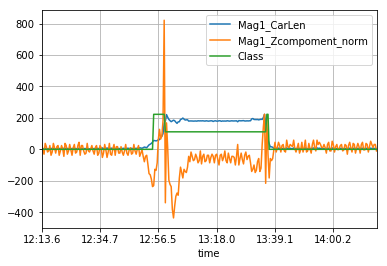

In [8]:
plt.figure(); 
df.plot(x='time', y=['Mag1_CarLen','Mag1_Zcompoment_norm', 'Class'], grid = True);

In [9]:
df.head(5)

Brand  Category  Forward  Backward  Sideway  Mag1_CarLen  Mag1_CarX  \
0  toyota  clotplus        1       0.0      0.0     5.991661       -2.2   
1  toyota  clotplus        1       0.0      0.0     2.846050        2.8   
2  toyota  clotplus        1       0.0      0.0     4.571652        0.8   
3  toyota  clotplus        1       0.0      0.0     6.920983       -4.2   
4  toyota  clotplus        1       0.0      0.0     3.082207        1.8   

   Mag1_CarY  Mag1_CarZ  Mag1_EnvX           ...            \
0        0.9       -5.5       50.2           ...             
1       -0.1        0.5       50.2           ...             
2       -0.1        4.5       50.2           ...             
3       -0.1       -5.5       50.2           ...             
4       -0.1       -2.5       50.2           ...             

   Mag1_Zcompoment_norm  Mag1_performance_XY_plane  \
0             37.800687                 605.016963   
1             -3.436426                 613.181466   
2            -30.927835                 609.796618   
3             37.800687                 601.016442   
4             17.182131                 611.498128   

   Mag1_cosine_variations_product_XY_plane  Mag1_cosine_variations_Kcriterion  \
0                                -1.022464                           5.848983   
1                                14.467555                           0.824503   
2                                -0.652603                          -1.784388   
3                                -2.494791                           6.401465   
4                                 1.007243                           2.841054   

   Mag1_square_deviation  Mag1_vectorial_deviation  \
0               5.991661                 37.641688   
1               2.846050                 14.544077   
2               4.571652                 25.739856   
3               6.920983                 42.202588   
4               3.082207                 16.736132   

   Mag1_combined_vectorial_deviation  Mag1_weighting_vectorial_deviation  \
0                          58.489827                           58.489827   
1                           8.245029                            8.245029   
2                         -17.843877                          -17.843877   
3                          64.014652                           64.014652   
4                          28.410544                           28.410544   

   Mag1_axis_diffence  Mag1_axis_abs_distance  
0                12.8                     8.6  
1                 5.8                     3.4  
2                 9.2                     5.4  
3                10.8                     9.8  
4                 8.6                     4.4  

[5 rows x 61 columns]